In [1]:
from datascience import *

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

import os
import networkx as nx
import pandas as pd

In [2]:
#PART A

In [3]:
raw_data = pd.read_csv("letter_edgelist.tsv", sep='\t')
raw_data

,#SENDER_ID,RECIPIENT_ID,DATE_FROM,DATE_TO,MS_ID,PLACE_ID,MS_REF
0,10102,18633,0,0,SP_84/63_f.49,0,SP 84/63 f.49
1,10407,24658,0,0,spo2_imcc-v003-p000_imcc-v003-p000-m0234-cm,3481,SP 63/25 f.55
2,10575,28163,0,0,Harley_7002_f.241,0,Harley 7002 f.241
3,10903,20638,0,0,Harley_7002_f.75,0,Harley 7002 f.75
4,10955,31585,0,0,SP_84/63_f.12,0,SP 84/63 f.12
...,...,...,...,...,...,...,...
139292,15618,29809,16030723,16030723,spo1_MQIS_SAL-v015-p015_mqes_sal-v015-p015-m04...,0,NaN
139293,20170,29809,16030723,16030723,spo1_MQIS_SAL-v015-p015_mqes_sal-v015-p015-m04...,4019,NaN
139294,11449,29809,16030724,16030724,spo1_MQIS_SAL-v015-p015_mqes_sal-v015-p015-m04...,0,NaN
139295,17019,7068,16030724,16030724,spo1_ELZ1-fd1580-td1625_elz1-fd1580-td1625-m13...,0,SP 15/35


In [4]:
raw_data_agg = raw_data.groupby(['#SENDER_ID', 'RECIPIENT_ID']).size().reset_index(name = 'weight')
raw_data_agg.sort_values(by = 'weight', ascending = False)

,#SENDER_ID,RECIPIENT_ID,weight
32382,30517,30478,563
25848,26415,30478,449
28988,28892,30478,442
7050,8067,28530,421
32287,30507,30478,390
...,...,...,...
15851,15617,32545,1
15850,15616,24566,1
15848,15615,13349,1
15846,15614,35838,1


In [5]:
letters_network = nx.from_pandas_edgelist(df = raw_data_agg, source = '#SENDER_ID', target = 'RECIPIENT_ID', edge_attr=True)

In [6]:
letters_network_directed = nx.from_pandas_edgelist(df = raw_data_agg, source = '#SENDER_ID', target = 'RECIPIENT_ID', create_using = nx.DiGraph(), edge_attr= True)

In [7]:
letters_degree_df =  pd.DataFrame({'id' : letters_network_directed.nodes(),
             'in_degree' : [y for (x,y) in letters_network_directed.in_degree()],
             'out_degree' : [y for (x,y) in letters_network_directed.out_degree()]
             })
letters_degree_df

,id,in_degree,out_degree
0,7,0,1
1,32642,141,25
2,9,0,1
3,33559,4,1
4,10,0,1
...,...,...,...
20555,38197,0,1
20556,38198,0,1
20557,38199,0,1
20558,40000,0,1


In [8]:
avg_in_degree = np.average(letters_degree_df['in_degree'])
avg_in_degree

1.9511186770428015

In [9]:
avg_out_degree = np.average(letters_degree_df['out_degree'])
avg_out_degree

1.9511186770428015

/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'In-degree VS Out-Degree of a Node')

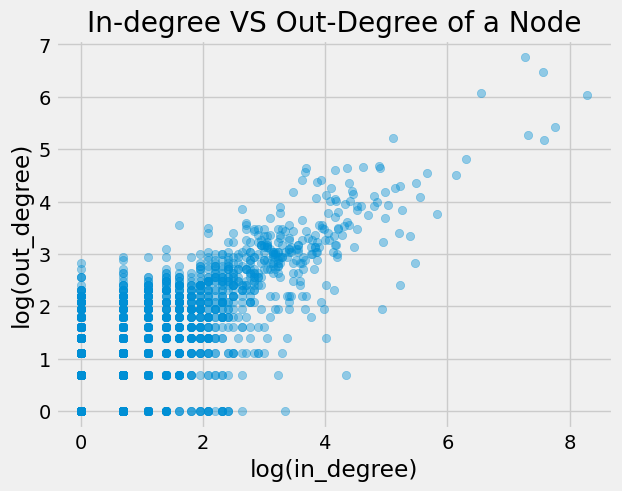

In [10]:
plt.scatter(np.log(letters_degree_df['in_degree']), np.log(letters_degree_df['out_degree']), alpha = 0.4)
plt.xlabel('log(in_degree)')
plt.ylabel('log(out_degree)')
plt.title('In-degree VS Out-Degree of a Node')

In [11]:
#PART B

In [12]:
#check that the undirected network was created correctly
nx.number_connected_components(letters_network)

942

In [13]:
def get_degree_list(g):
    return([deg_val for (node, deg_val) in g.degree()])

In [14]:
#The degree of all the nodes in our network
letters_network_degrees = get_degree_list(letters_network)

In [15]:
#One configuration model based on this
config_model = nx.configuration_model(letters_network_degrees)

In [16]:
#Simplify configuration network from multigraph to graph object
simple_config_model = nx.Graph(config_model)
simple_config_model.remove_edges_from(nx.selfloop_edges(simple_config_model))

In [17]:
#Claim 1: Clustering Coefficient (CC)
#The clustering coefficient of our observed network
observed_cc = nx.average_clustering(letters_network)
observed_cc

0.1747101288269982

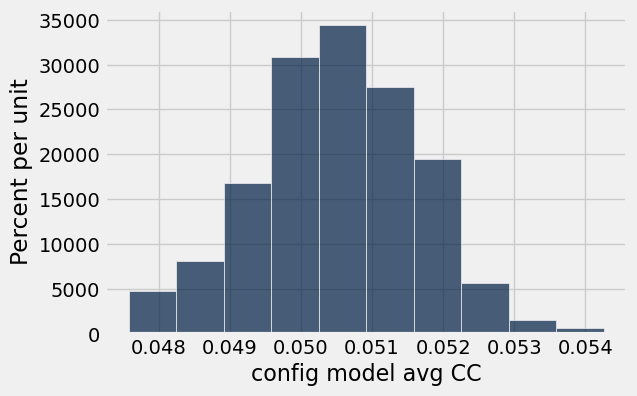

In [18]:
#Simulate many random configuration models based on the degrees of our original network
cc_results = make_array()

for i in range(500):
    current_config_model = nx.configuration_model(letters_network_degrees)
    current_config_model = nx.Graph(current_config_model)
    current_config_model.remove_edges_from(nx.selfloop_edges(current_config_model))
    cc_results = np.append(cc_results, nx.average_clustering(current_config_model))
    
tbl_cc = Table().with_column('config model avg CC', cc_results)
tbl_cc.hist()

In [19]:
tbl_cc

config model avg CC
0.0486235
0.0503031
0.051743
0.0521699
0.0516975
0.0513272
0.0522846
0.0502904
0.0498746
0.0493223


In [20]:
#PART C

In [21]:
#Load in people labels data
raw_data_people_labels = pd.read_csv("people_labels.tsv", sep='\t')
raw_data_people_labels

,3,(Monseigneur)
0,7,--- Parker the elder
1,9,--- Thomas
2,10,--- Topcliffe
3,12,...
4,13,11 others
...,...,...
20554,38197,"Robert Stewart, 1st Earl of March"
20555,38198,John Porterfield
20556,38199,Margaret of Savoy's Council
20557,38200,Thomas Sherley


In [22]:
#Merge dataframe from part A with our people labels dataframe. 
#'3' column in our people labels data is the same as 'id' in our dataframe from part A
letters_degree_names = letters_degree_df.merge(raw_data_people_labels, left_on = 'id', right_on = '3').drop('3', axis = 1).rename(columns = {'(Monseigneur)': 'Name'})
letters_degree_names

,id,in_degree,out_degree,Name
0,7,0,1,--- Parker the elder
1,32642,141,25,Thomas Fanshawe
2,9,0,1,--- Thomas
3,33559,4,1,Thomas Wotton
4,10,0,1,--- Topcliffe
...,...,...,...,...
20554,38197,0,1,"Robert Stewart, 1st Earl of March"
20555,38198,0,1,John Porterfield
20556,38199,0,1,Margaret of Savoy's Council
20557,40000,0,1,-


In [23]:
#Filter the dataframe to find the people we're interested in
letters_degree_names[letters_degree_names['Name'] == 'Henry VIII']

,id,in_degree,out_degree,Name
51,11844,704,430,Henry VIII


In [24]:
#record the id of each person to use to find clustering coefficient and eigenvector centrality later
henry_id = letters_degree_names[letters_degree_names['Name'] == 'Henry VIII']['id'].iloc[0]
henry_id

11844

In [25]:
letters_degree_names[letters_degree_names['Name'] == 'Katharine of Arragon']

,id,in_degree,out_degree,Name
611,16721,22,22,Katharine of Arragon


In [26]:
katharine_id = letters_degree_names[letters_degree_names['Name'] == 'Katharine of Arragon']['id'].iloc[0]
katharine_id

16721

In [27]:
letters_degree_names[letters_degree_names['Name'] == 'Thomas Cromwell, Earl of Essex']

,id,in_degree,out_degree,Name
116,32545,1960,177,"Thomas Cromwell, Earl of Essex"


In [28]:
thomas_id = letters_degree_names[letters_degree_names['Name'] == 'Thomas Cromwell, Earl of Essex']['id'].iloc[0]
thomas_id

32545

In [29]:
letters_degree_names[letters_degree_names['Name'] == 'Emery Molyneux']

,id,in_degree,out_degree,Name
5085,8417,0,2,Emery Molyneux


In [30]:
emery_id = letters_degree_names[letters_degree_names['Name'] == 'Emery Molyneux']['id'].iloc[0]
emery_id

8417

In [31]:
letters_degree_names[letters_degree_names['Name'] == 'Desiderius Erasmus']

,id,in_degree,out_degree,Name
282,6113,39,96,Desiderius Erasmus


In [32]:
desiderius_id = letters_degree_names[letters_degree_names['Name'] == 'Desiderius Erasmus']['id'].iloc[0]
desiderius_id

6113

In [33]:
#dictionary where the values are the clustering coefficient of all nodes in our network and the keys are the ids of the nodes
cc_all = nx.clustering(letters_network_directed)

In [34]:
#Dictionary containing ids and eigenvector centrality of each of our nodes
ev_centrality_all = nx.eigenvector_centrality(letters_network_directed)

In [35]:
#clustering coefficient of an individual
henry_cc = cc_all[henry_id]
henry_cc

0.007248701306790577

In [36]:
#eigenvector centrality of an individual
henry_ev_centrality = ev_centrality_all[henry_id]
henry_ev_centrality

0.08961102002782177

In [37]:
katharine_cc = cc_all[katharine_id]
katharine_cc

0.11689691817215728

In [38]:
katharine_ev_centrality = ev_centrality_all[katharine_id]
katharine_ev_centrality

0.004076069220006484

In [39]:
thomas_cc = cc_all[thomas_id]
thomas_cc

0.0013874739561082375

In [40]:
thomas_ev_centrality = ev_centrality_all[thomas_id]
thomas_ev_centrality

0.08399252390052572

In [41]:
emery_cc = cc_all[emery_id]
emery_cc

1.0

In [42]:
emery_ev_centrality = ev_centrality_all[emery_id]
emery_ev_centrality

9.418064404341942e-32

In [43]:
desiderius_cc = cc_all[desiderius_id]
desiderius_cc

0.022069424420538983

In [44]:
desiderius_ev_centrality = ev_centrality_all[desiderius_id]
desiderius_ev_centrality

0.004448673389188995